# Modelling of catalogue data
This notebook describes how to sample from a catalogue based data set of
- image positions (with astrometric uncertainties)
- relative time delays (with uncertainties)
- relative image brightness (with uncertainties)

In [1]:
import numpy as np
import time

In [2]:
# the data set is
z_lens = 0.50175
z_source = 2.0

# image positions
ximg = np.array([-0.72406457,  0.30681026,  2.05506938, -0.92206211])  # units of arcsec
yimg = np.array([ 0.74929728, -1.31371359,  0.89928639, -1.10462838])  # units of arcsec
astrometry_sigma = 0.004  # 1-sigma astrometric uncertainties of the image positions (assuming equal precision)

# time delays
delay = np.array([162.91199324, 132.58626401,   0.        , 122.28496583])  # units of days
d_dt = delay[1:] - delay[0]  # lenstronomy definition of relative time delay is in respect of first image in the list (full covariance is in planning)
d_dt_sigma = np.array([2, 2, 2])  # 1-sigma uncertainties in the time-delay measurement (in units of days)

# image brightness
image_amps = np.array([0.7265755, 1.5334439,  1.7366254,  3.2545505])  # amplitude (in arbitrary linear units, not magnitudes)
image_amps_sigma = np.array([0.1, 0.5, 0.3, 0.5])
flux_ratios = image_amps[1:] / image_amps[0]
flux_ratio_errors = np.array([0.1, 0.1, 0.1])

## Model settings
This part is equal to the imaging simulation of lenstronomy. We refer to other notebooks and the documentation for details.

In [3]:
# lens model choicers
lens_model_list = ['SPEMD', 'SHEAR']

fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
kwargs_lens_init.append({'theta_E': 1.7, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0.})
kwargs_lens_sigma.append({'theta_E': .5, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append({'e1': 0.0, 'e2': 0.0})
kwargs_lens_sigma.append({'e1': 0.1, 'e2': 0.1})
kwargs_lower_lens.append({'e1': -0.2, 'e2': -0.2})
kwargs_upper_lens.append({'e1': 0.2, 'e2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]



point_source_list = ['LENSED_POSITION']
fixed_ps = [{'ra_image': ximg, 'dec_image': yimg}]  # we fix the image position coordinates
kwargs_ps_init = fixed_ps
kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(ximg)), 'dec_image': 0.01 * np.ones(len(ximg))}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(ximg)), 'dec_image': -10 * np.ones(len(ximg))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(ximg)), 'dec_image': 10 * np.ones(len(ximg))}]

ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]

# we let some freedome in how well the actual image positions are matching those given by the data (indicated as 'ra_image', 'dec_image' and held fixed while fitting)
fixed_cosmo = {}
kwargs_cosmo_init = {'D_dt': 5000, 'delta_x_image': np.zeros_like(ximg), 'delta_y_image': np.zeros_like(ximg)}
kwargs_cosmo_sigma = {'D_dt': 10000, 'delta_x_image': np.ones_like(ximg) * astrometry_sigma, 'delta_y_image': np.ones_like(ximg) * astrometry_sigma}
kwargs_lower_cosmo = {'D_dt': 0, 'delta_x_image': np.ones_like(ximg) * (-1), 'delta_y_image': np.ones_like(ximg) * (-1)}
kwargs_upper_cosmo = {'D_dt': 10000, 'delta_x_image': np.ones_like(ximg) * (1), 'delta_y_image': np.ones_like(ximg) * (1)}
cosmo_params = [kwargs_cosmo_init, kwargs_cosmo_sigma, fixed_cosmo, kwargs_lower_cosmo, kwargs_upper_cosmo]


kwargs_params = {'lens_model': lens_params,
                'point_source_model': ps_params,
                'cosmography': cosmo_params}


## setup options for likelihood and parameter sampling

In [4]:
kwargs_constraints = {'num_point_source_list': [4],
                      'solver_type': 'PROFILE_SHEAR',  # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeld
                      'cosmo_type': 'D_dt',  # sampling of the time-delay distance
                      'point_source_offset': True  # explicit modelling of the astrometric imperfection of the point source positions
                              }

kwargs_likelihood = {'check_bounds': True,
                     'point_source_likelihood': True,
                     'position_uncertainty': astrometry_sigma,
                     'check_solver': True,
                     'solver_tolerance': 0.001,
                     
                     'time_delay_likelihood': True,
                     'image_likelihood': False, # this needs to be explicitly given when not having imaging data
                     
                     'flux_ratio_likelihood': True  # enables the flux ratio likelihood 
                             }

kwargs_data_joint = {'time_delays_measured': d_dt,
                     'time_delays_uncertainties': d_dt_sigma,
                      'flux_ratios': flux_ratios, 'flux_ratio_errors': flux_ratio_errors}

kwargs_model = {'lens_model_list': lens_model_list, 
                'point_source_model_list': point_source_list
                 }

In [5]:
from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
fitting_kwargs_list = [#['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}],
                       ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],]

start_time = time.time()
chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
lens_result, source_result, lens_light_result, ps_result, cosmo_result = fitting_seq.best_fit()
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Computing the PSO ...


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
max iteration reached! stoping
0.0031230606753200607 reduced X^2 of best position
-0.014053773038940273 logL
-9 effective number of data points
[{'theta_E': 1.692650096663212, 'gamma': 1.9974871325103662, 'e1': -0.2511444451999312, 'e2': -0.4604489121380551, 'center_x': -0.0003715339878764634, 'center_y': 0.0005219022935253014}, {'e1': -0.0004686280318250766, 'e2': -0.0011573876746058707, 'ra_0': 0, 'dec_0': 0}] lens result
[] source result
[] lens light result
[{'ra_image': array([-0.72406457,  0.30681026,  2.05506938, -0.92206211]), 'dec_image': array([ 0.74929728, -1.31371359,  0.89928639, -1.10462838]), 'point_amp': 1}] point source result
{'D_dt': 2950.3316604495553, 'delta_x_image': array([-3.17427950e-06,  5.15344775e-06,  2.53398821e-04,  5.49628355e-04]), 'delta_y_image': array([-2.00354682e-05,  7.88083560e-05, -1.64970322e-04, -1.34189736e-04])} cosmo result
39.93978500366211 time used for PSO PSO
39.969494104385376 total time needed for comput

In [6]:
#and now we run the MCMC
fitting_kwargs_list = [
    ['MCMC', {'n_burn': 200, 'n_run': 200, 'walkerRatio': 10,'sigma_scale': .1}]
]
chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
lens_result, source_result, lens_light_result, ps_result, cosmo_result = fitting_seq.best_fit()

Computing the MCMC...
Number of walkers =  120
Burn-in iterations:  200
Sampling iterations: 200


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


InMemoryStorageUtil does not support storeRandomState
162.7279851436615 time taken for MCMC sampling


In [7]:
print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
import corner


# import the parameter handling class #
from lenstronomy.Sampling.parameters import Param
import lenstronomy.Util.param_util as param_util
# make instance of parameter class with given model options, constraints and fixed parameters #

param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, kwargs_fixed_cosmo=fixed_cosmo, 
              kwargs_lens_init=lens_result, **kwargs_constraints)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.lens_analysis import LensAnalysis
lensAnalysis = LensAnalysis(kwargs_model)

mcmc_new_list = []
labels_new = [r"$\theta_E$", r"$\gamma$", r"$\phi_{lens}$", r"$q$", r"$\phi_{ext}$", r"$\gamma_{ext}$", r"$D_{\Delta t}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_lens_out, kwargs_light_source_out, kwargs_light_lens_out, kwargs_ps_out, kwargs_cosmo = param.args2kwargs(samples_mcmc[i])
    D_dt = kwargs_cosmo['D_dt']
    theta_E = kwargs_lens_out[0]['theta_E']
    gamma = kwargs_lens_out[0]['gamma']
    e1, e2 = kwargs_lens_out[0]['e1'], kwargs_lens_out[0]['e2']
    phi, q = param_util.ellipticity2phi_q(e1, e2)
    phi_ext, gamma_ext = lensAnalysis._lensModelExtensions.external_shear(kwargs_lens_out)
    mcmc_new_list.append([theta_E, gamma, phi, q, phi_ext, gamma_ext, D_dt])




number of non-linear parameters in the MCMC process:  12
parameters in order:  ['gamma_lens', 'e1_lens', 'e2_lens', 'D_dt', 'delta_x_image', 'delta_x_image', 'delta_x_image', 'delta_x_image', 'delta_y_image', 'delta_y_image', 'delta_y_image', 'delta_y_image']
number of evaluations in the MCMC process:  24000


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/scipy-1.1.0-py3.6-macosx-10.13-x86_64.egg/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


3084.7745025636614


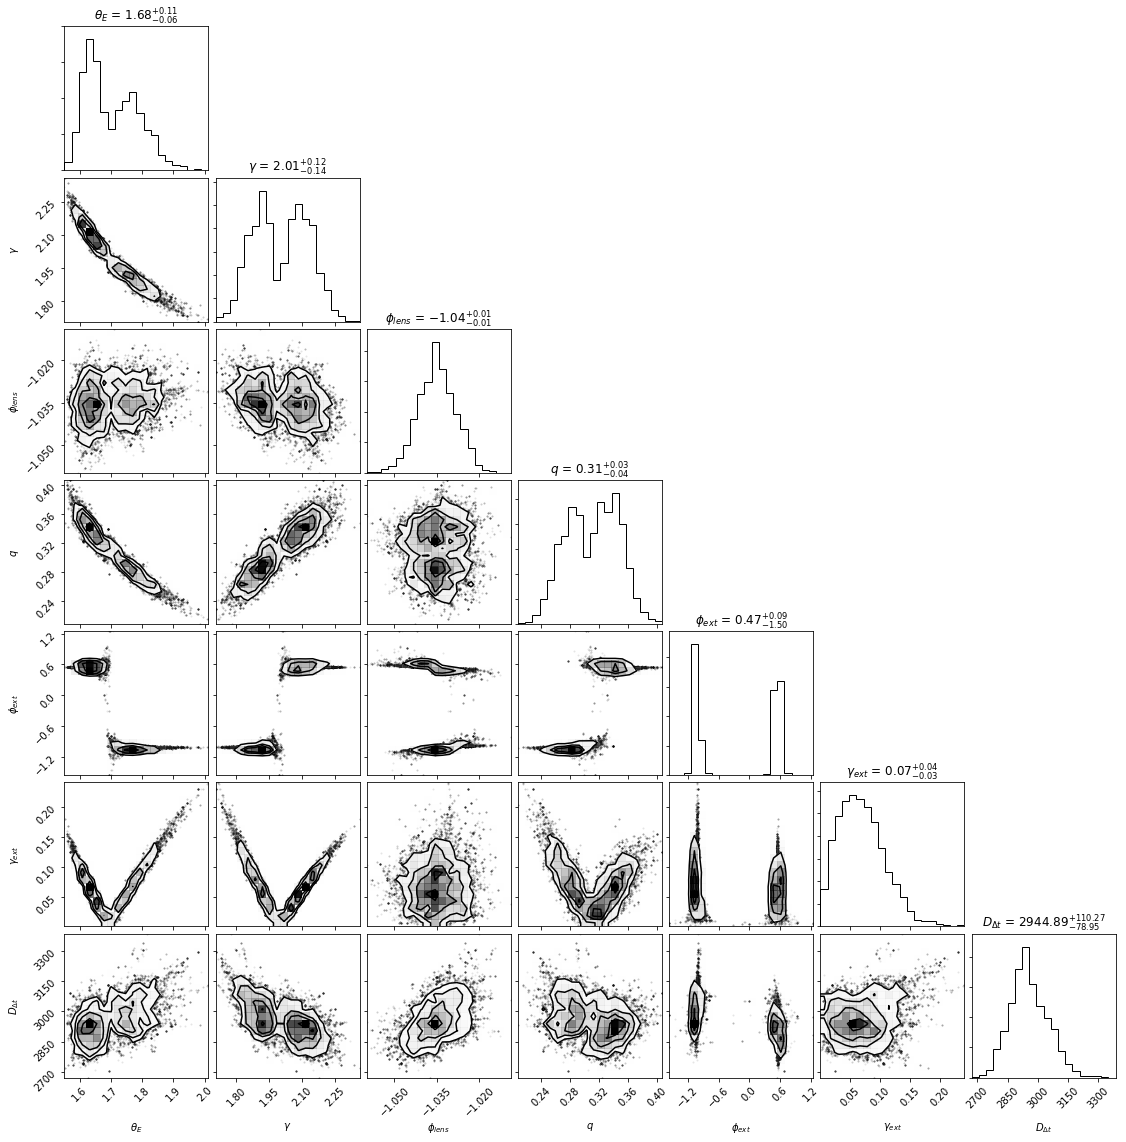

In [8]:
plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)

# and here the predicted angular diameter distance from a default cosmology (attention for experimenter bias!)
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
lensCosmo = LensCosmo(z_lens=z_lens, z_source=z_source)
print(lensCosmo.D_dt)